# NLP with Hotel Review

### Introduction

We are tasked with helping Hotel Management Inc. better understand what qualities of a hotel stay contribute to greater customer satisfaction and higher ratings. For this analysis, we are provided with a large data set consisting of hotel reviews (text fields for positive and negative comments) and details about the stay (hotel location, time & length of stay, etc). The target column of interest is **Reviewer_Score** that encodes positive sentiment as 1 and negative as 0.





We will begin with some Exploratory Data Analysis (EDA), and then move into data processing, modelling, and iteration over model improvements.

 ### Table of contents

   
 - [Libraries ](#toc1_)    
 - [Setup ](#toc2_)    
 - [EDA](#toc3_)    
 - [Data Loading ](#toc4_)      
   - [Data Dictionary ](#toc4_1_)    
   - [Data Cleaning](#toc4_2_)    
   - [Data Visualizations](#toc4_3_)       
 - [PreProcessing ](#toc5_)    
 - [Modelling ](#toc6_)    
   - [Modelling: Logistic Regression (LR)](#toc6_1_)    
   - [Modelling:  PCA with a Decision Tree (DT)](#toc6_2_)    
   - [Comparison of LR with PCA + DT ](#toc6_3_)    
   - [Confusion matrix, Precision and Recall score ](#toc6__4)    
- [Conclusion ](#toc7_)
 
 <!-- vscode-jupyter-toc-config
  numbering=false
  anchor=true
  flat=false
  minLevel=2
  maxLevel=3
  /vscode-jupyter-toc-config -->
 <!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## Libraries

In [7]:
#Data Loading and Manipulation
import pandas as pd
import numpy as np
import scipy as sp
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from scipy import sparse
import re
import string
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Setup

In [9]:

# Setting figure size globally in the notebook
plt.rcParams["figure.figsize"] = (8.0, 6.0)

# Brand colors dictionary
brand_colors = {
    "Denim": "#1358DB",
    "Supernova": "#FFCF00",
    # "Black": "#000000",
    # "Dark Blue": "#101D42",
    # "White": "#FFFFFF",
    "Dark Gray": "#6F6F6F",
    # "Light Gray 1": "#F6F6F4",
    "Light Gray 2": "#ADBDCC"
}

# Create a matplotlib colormap
brand_cmap = plt.cm.colors.ListedColormap(list(brand_colors.values()))
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=brand_colors.values())

# Setting pandas display options
pd.set_option('display.max_colwidth', 200)

# Uncomment if necessary
# from warnings import filterwarnings
# filterwarnings(action='ignore')

#

## Exploratory Data Analysis

First, let's load the data and understand what we are working with and then perform EDA on the data and mention 3-4 observations from which you can draw actionable insights. In your EDA, you may consider creating a data dictionary, basic statistical analysis, data visualizations, data cleaning and preprocessing to prepare the data for modeling.

In [13]:
# Load the Hotel Review dataset
nlp_df = pd.read_csv(r"Hotel_Reviews.csv")

In [14]:
# check to see if the dataset loaded correctly
nlp_df.head()

,Unnamed: 0,Additional_Number_of_Scoring,Average_Score,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,...,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed
0,0,194,7.7,I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed ...,397,1403,Only the park outside of the hotel was beautiful,11,7,0,...,0,1,1,0,0,0,0,0,1,6
1,1,194,7.7,No Negative,0,1403,No real complaints the hotel was great great location surroundings rooms amenities and service Two recommendations however firstly the staff upon check in are very confusing regarding deposit pay...,105,7,0,...,0,0,1,0,0,0,0,0,1,4
2,2,194,7.7,Rooms are nice but for elderly a bit difficult as most rooms are two story with narrow steps So ask for single level Inside the rooms are very very basic just tea coffee and boiler and no bar emp...,42,1403,Location was good and staff were ok It is cute hotel the breakfast range is nice Will go back,21,9,0,...,0,0,1,0,0,0,0,0,1,3
3,3,194,7.7,My room was dirty and I was afraid to walk barefoot on the floor which looked as if it was not cleaned in weeks White furniture which looked nice in pictures was dirty too and the door looked lik...,210,1403,Great location in nice surroundings the bar and restaurant are nice and have a lovely outdoor area The building also has quite some character,26,1,0,...,0,0,1,0,0,0,0,0,1,3
4,4,194,7.7,You When I booked with your company on line you showed me pictures of a room I thought I was getting and paying for and then when we arrived that s room was booked and the staff told me we could ...,140,1403,Amazing location and building Romantic setting,8,3,0,...,0,1,1,0,0,0,0,0,1,2


In [15]:
nlp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Unnamed: 0                                  515738 non-null  int64  
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Average_Score                               515738 non-null  float64
 3   Negative_Review                             515738 non-null  object 
 4   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 5   Total_Number_of_Reviews                     515738 non-null  int64  
 6   Positive_Review                             515738 non-null  object 
 7   Review_Total_Positive_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews_Reviewer_Has_Given  515738 non-null  int64  
 9   Reviewer_Score                              515738 non-null  int64  
 

The hotel review dataframe has 515738 rows and 30 columns

### Data Dictionary

| Column Name                                  | Data Type | Description                                                   |
| -------------------------------------------- | --------- | ------------------------------------------------------------- |
| `Unnamed: 0`                                 | `int64`   | Index column (likely auto-generated when saving/loading CSV). |
| `Additional_Number_of_Scoring`               | `int64`   | Number of additional reviews used for scoring.                |
| `Average_Score`                              | `float64` | Average hotel review score.                                   |
| `Negative_Review`                            | `object`  | Text of the negative review left by the reviewer.             |
| `Review_Total_Negative_Word_Counts`          | `int64`   | Count of words in the negative review.                        |
| `Total_Number_of_Reviews`                    | `int64`   | Total number of reviews for the hotel.                        |
| `Positive_Review`                            | `object`  | Text of the positive review left by the reviewer.             |
| `Review_Total_Positive_Word_Counts`          | `int64`   | Count of words in the positive review.                        |
| `Total_Number_of_Reviews_Reviewer_Has_Given` | `int64`   | Total number of reviews the reviewer has written.             |
| `Reviewer_Score`                             | `int64`   | The score (rating) given by the reviewer.                     |
| `Days_Since_Review`                          | `int64`   | Number of days since the review was written.                  |
| `Latitude`                                   | `float64` | Geographical latitude of the hotel.                           |
| `Longitude`                                  | `float64` | Geographical longitude of the hotel.                          |
| `Day`                                        | `int64`   | Day of the review date.                                       |
| `Month`                                      | `int64`   | Month of the review date.                                     |
| `Year`                                       | `int64`   | Year of the review date.                                      |
| `Reviewer_Nationality_Australia`             | `int64`   | 1 if reviewer is from Australia, else 0.                      |
| `Reviewer_Nationality_Ireland`               | `int64`   | 1 if reviewer is from Ireland, else 0.                        |
| `Reviewer_Nationality_UAE`                   | `int64`   | 1 if reviewer is from UAE, else 0.                            |
| `Reviewer_Nationality_UK`                    | `int64`   | 1 if reviewer is from UK, else 0.                             |
| `Reviewer_Nationality_USA`                   | `int64`   | 1 if reviewer is from USA, else 0.                            |
| `Trip_type_Business`                         | `int64`   | 1 if trip was for business, else 0.                           |
| `Trip_type_Couple`                           | `int64`   | 1 if trip was with a couple, else 0.                          |
| `Trip_type_Family`                           | `int64`   | 1 if trip was with family, else 0.                            |
| `Trip_type_Group`                            | `int64`   | 1 if trip was with a group, else 0.                           |
| `Trip_type_Other`                            | `int64`   | 1 if trip was for another purpose, else 0.                    |
| `Trip_type_Solo`                             | `int64`   | 1 if trip was solo, else 0.                                   |
| `Leisure_Trip`                               | `int64`   | 1 if trip was for leisure, else 0.                            |
| `Nights_Stayed`                              | `int64`   | Number of nights the guest stayed.                            |

In [18]:
# Descriptive  statistics of numeric columns
print("\nBasic Statistics:")
display(nlp_df.describe())


Basic Statistics:


,Unnamed: 0,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Days_Since_Review,Latitude,...,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,257868.500000,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,0.570006,354.441932,49.432419,...,0.068711,0.365121,0.110936,0.116627,0.508594,0.072143,0.116199,0.075502,0.810059,2.362122
std,148880.880902,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,0.495075,208.928124,3.460237,...,0.252963,0.481465,0.314053,0.320976,0.499927,0.258725,0.320463,0.264199,0.392255,1.646808
min,0.000000,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,41.328376,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,128934.250000,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.000000,175.000000,48.214066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,257868.500000,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,1.000000,353.000000,51.499981,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,386802.750000,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,1.000000,527.000000,51.516288,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,515737.000000,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,1.000000,730.000000,52.400181,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,31.000000


### Data Cleaning

In [20]:
# Dropping Unnamed column
nlp_df=nlp_df.drop(columns=['Unnamed: 0'])
# Check if the column is dropped
nlp_df.head()

,Additional_Number_of_Scoring,Average_Score,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Days_Since_Review,...,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed
0,194,7.7,I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed ...,397,1403,Only the park outside of the hotel was beautiful,11,7,0,0,...,0,1,1,0,0,0,0,0,1,6
1,194,7.7,No Negative,0,1403,No real complaints the hotel was great great location surroundings rooms amenities and service Two recommendations however firstly the staff upon check in are very confusing regarding deposit pay...,105,7,0,0,...,0,0,1,0,0,0,0,0,1,4
2,194,7.7,Rooms are nice but for elderly a bit difficult as most rooms are two story with narrow steps So ask for single level Inside the rooms are very very basic just tea coffee and boiler and no bar emp...,42,1403,Location was good and staff were ok It is cute hotel the breakfast range is nice Will go back,21,9,0,3,...,0,0,1,0,0,0,0,0,1,3
3,194,7.7,My room was dirty and I was afraid to walk barefoot on the floor which looked as if it was not cleaned in weeks White furniture which looked nice in pictures was dirty too and the door looked lik...,210,1403,Great location in nice surroundings the bar and restaurant are nice and have a lovely outdoor area The building also has quite some character,26,1,0,3,...,0,0,1,0,0,0,0,0,1,3
4,194,7.7,You When I booked with your company on line you showed me pictures of a room I thought I was getting and paying for and then when we arrived that s room was booked and the staff told me we could ...,140,1403,Amazing location and building Romantic setting,8,3,0,10,...,0,1,1,0,0,0,0,0,1,2


In [21]:
# Check for duplicate rows
print("\nNumber of Duplicate Rows:")
nlp_df.duplicated().sum()


Number of Duplicate Rows:


539

In [22]:
# Percentage of duplicates rows
print("\nPercentage of Duplicates :")
nlp_df.duplicated().mean()*100


Percentage of Duplicates :


0.1045104297143123

We can drop the duplicate rows  since there are 0.1% of the dataset

In [24]:
#Dropping duplicate rows
nlp_df = nlp_df.drop_duplicates()
# Check again for duplicates after dropping
print("\nNumber of Duplicate Rows After Droping:")
nlp_df.duplicated().sum()


Number of Duplicate Rows After Droping:


0

In [25]:

# Check for missing values
print("\nMissing Values:")
print(nlp_df.isnull().sum())



Missing Values:
Additional_Number_of_Scoring                  0
Average_Score                                 0
Negative_Review                               0
Review_Total_Negative_Word_Counts             0
Total_Number_of_Reviews                       0
Positive_Review                               0
Review_Total_Positive_Word_Counts             0
Total_Number_of_Reviews_Reviewer_Has_Given    0
Reviewer_Score                                0
Days_Since_Review                             0
Latitude                                      0
Longitude                                     0
Day                                           0
Month                                         0
Year                                          0
Reviewer_Nationality_Australia                0
Reviewer_Nationality_Ireland                  0
Reviewer_Nationality_UAE                      0
Reviewer_Nationality_UK                       0
Reviewer_Nationality_USA                      0
Reviewer_Nationality_Ot

In [26]:
#Checking for null values 
print("\nNull Values in Each Column:")
nlp_df.isna().sum()


Null Values in Each Column:


Additional_Number_of_Scoring                  0
Average_Score                                 0
Negative_Review                               0
Review_Total_Negative_Word_Counts             0
Total_Number_of_Reviews                       0
Positive_Review                               0
Review_Total_Positive_Word_Counts             0
Total_Number_of_Reviews_Reviewer_Has_Given    0
Reviewer_Score                                0
Days_Since_Review                             0
Latitude                                      0
Longitude                                     0
Day                                           0
Month                                         0
Year                                          0
Reviewer_Nationality_Australia                0
Reviewer_Nationality_Ireland                  0
Reviewer_Nationality_UAE                      0
Reviewer_Nationality_UK                       0
Reviewer_Nationality_USA                      0
Reviewer_Nationality_Other              

There are no null values in the dataset, so we can proceed with further analysis and modeling without needing to handle missing data.

### Data  visualizations

C:\Users\karni\anaconda3\envs\ml_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


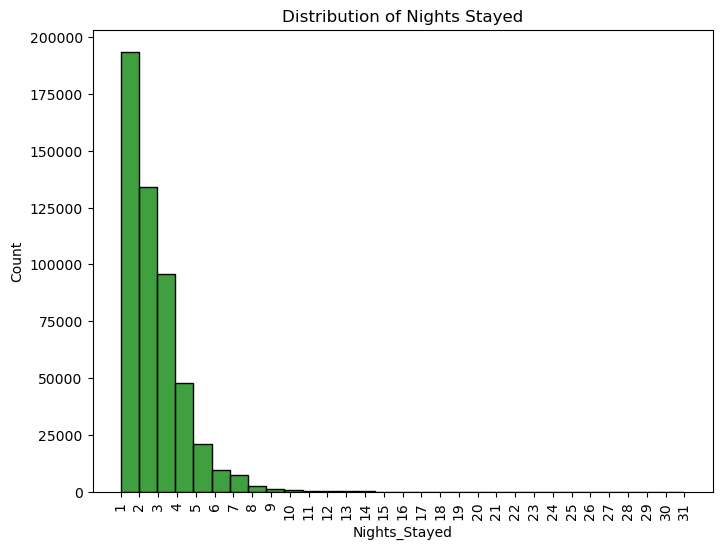

In [29]:
# Distrubtion of Average nights 
cols=nlp_df['Nights_Stayed'].nunique()
plt.figure()

sns.histplot(nlp_df['Nights_Stayed'], bins=cols, kde=False, color='green')
plt.title('Distribution of Nights Stayed')
plt.xticks(range(1,cols+1), rotation=90) 
plt.xlabel('Nights_Stayed')
plt.ylabel('Count')
plt.show()


Nights stayed are mostly in the 0-5 night range, the data seemed to be left skewed

C:\Users\karni\anaconda3\envs\ml_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


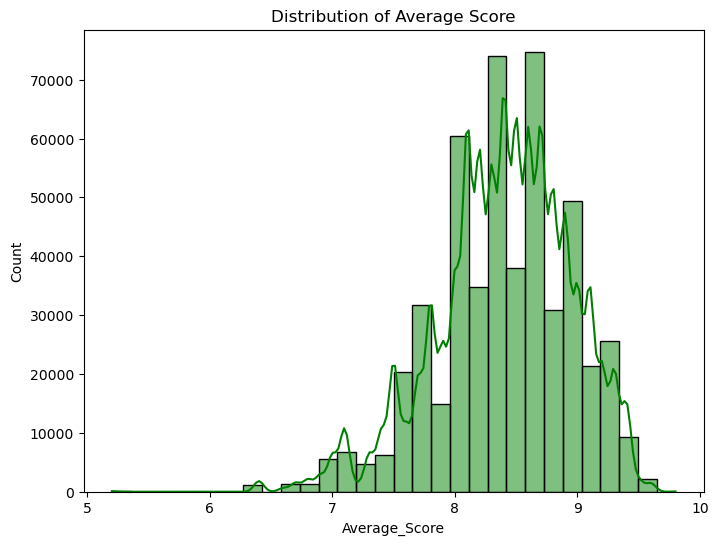

In [31]:
# Distribution of average score
plt.figure()
sns.histplot(nlp_df['Average_Score'], bins=30, kde=True, color='green')
plt.title('Distribution of Average Score')
plt.xlabel('Average_Score')
plt.ylabel('Count')
plt.show()

Insights from the distribution of average score:

- The scores are heavily concentrated between 7 and 9
- There are notable peaks around 8 and 9, suggesting these are the most common average scores
- Very few scores fall below 6 or above 9.5, indicating a tight clustering of performance


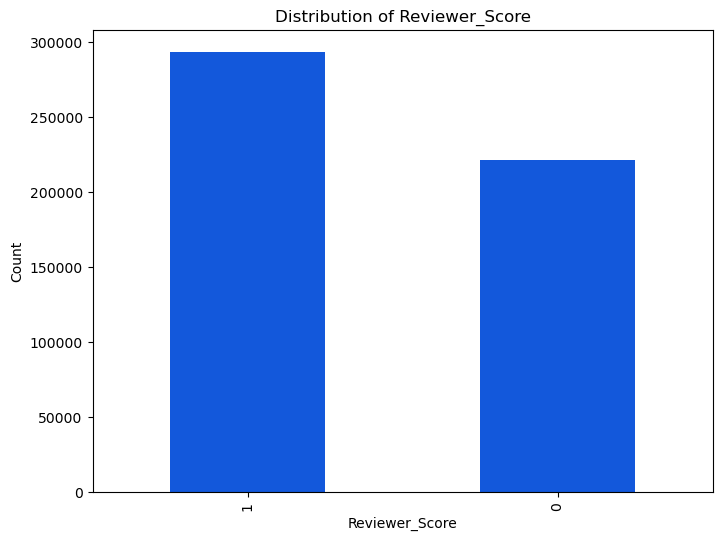

In [33]:
# Distribution of Reviewer_Score
plt.figure()
nlp_df['Reviewer_Score'].value_counts().plot(kind='bar')
plt.title('Distribution of Reviewer_Score')
plt.xlabel('Reviewer_Score')
plt.ylabel('Count')
plt.show()

- The majority of reviewers gave a score of 1, indicating a generally positive or affirmative response.
- A substantial number still gave a score of 0, so while the sentiment leans positive, there's a significant portion of dissent or negative feedback.


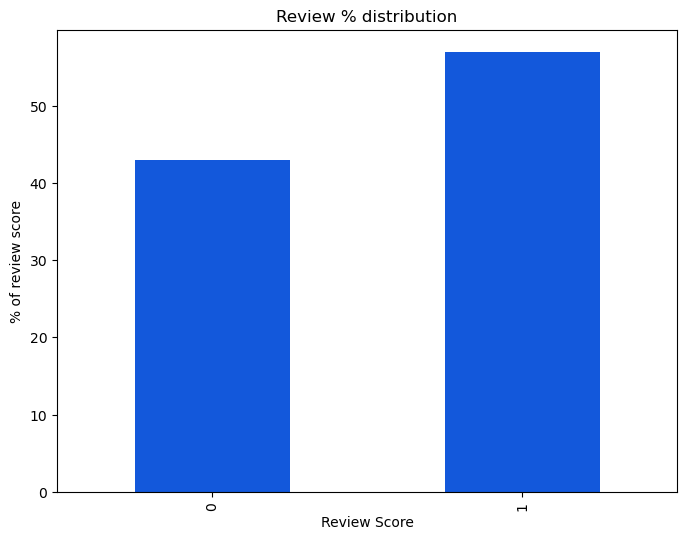

In [35]:
# Percentage distribution of Reviewer_Score
nlp_df['Reviewer_Score'].value_counts(normalize=True).multiply(100).sort_index().plot(
    kind="bar",
    xlabel="Review Score",
    ylabel="% of review score",
    title="Review % distribution"
)
plt.show()

 We can see that overall, 45% of the reviews are negative so there is some **imbalance between the classes**.

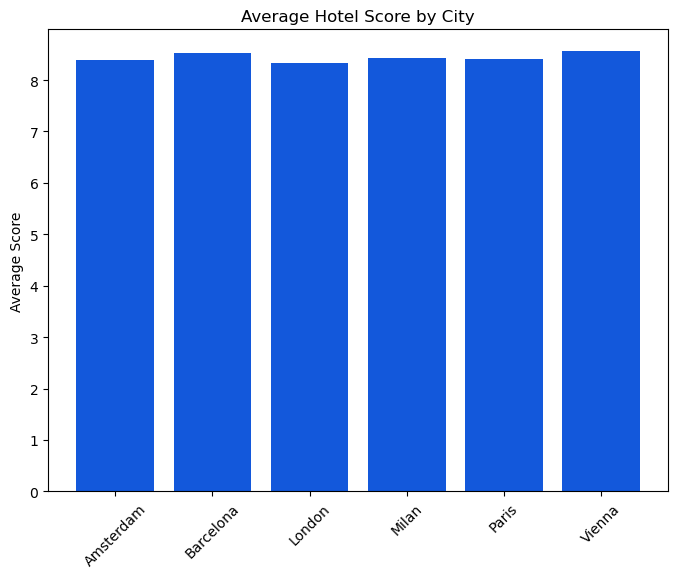

In [37]:

# Average Score by City
city_cols = [col for col in nlp_df.columns if col.startswith('Hotel_Address_')]
city_avg = {}
for city in city_cols:
    city_avg[city.replace('Hotel_Address_', '')] = nlp_df.loc[nlp_df[city]==1, 'Average_Score'].mean()
plt.figure()
plt.bar(city_avg.keys(), city_avg.values())
plt.title('Average Hotel Score by City')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.show()


Similar average scores across cities suggest consistent hotel quality, but some cities like **Paris** and **London** have slightly lower scores, indicating potential areas for improvement in those locations.

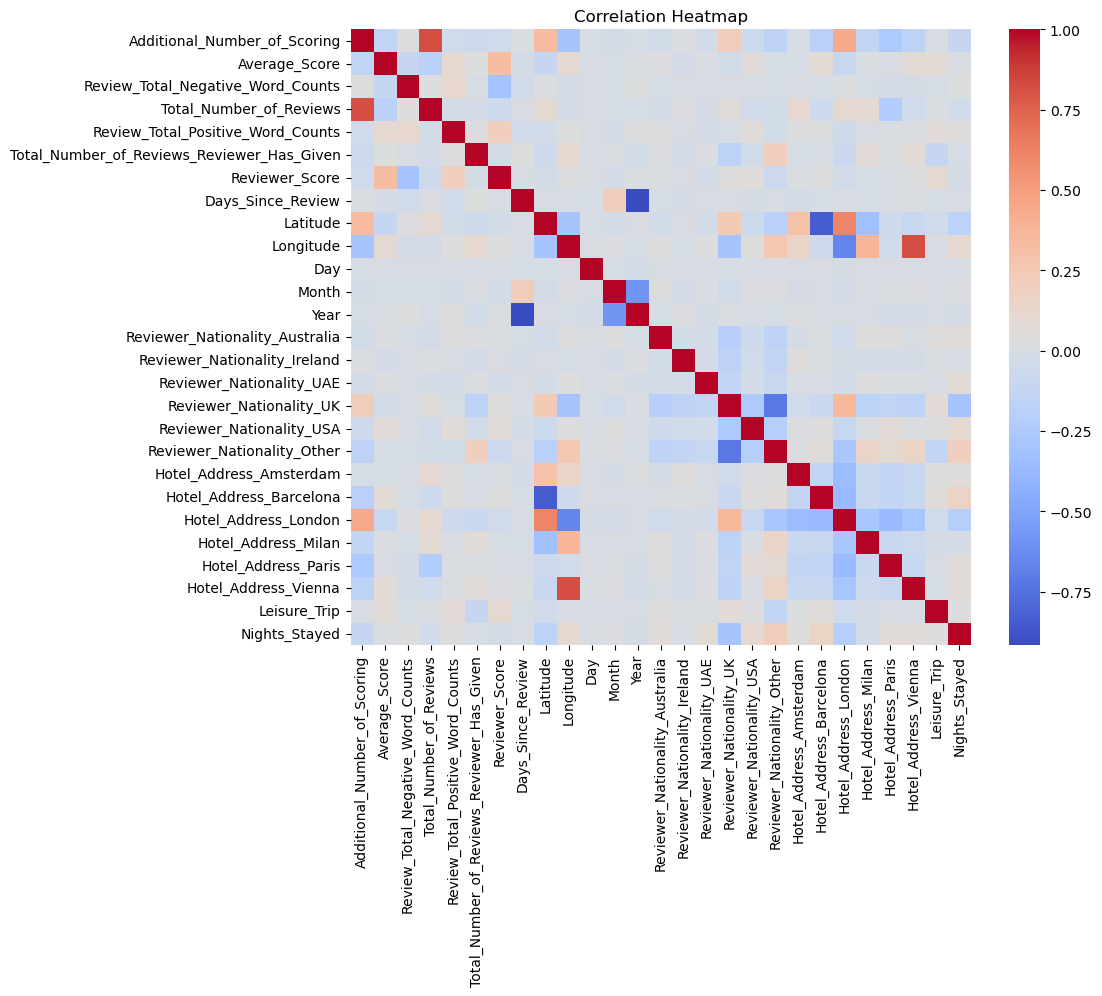

In [39]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(nlp_df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

Strong correlations  between:
-   Reviewer_Score and Average_Score
-   Review_Total_Positive_Word_Counts and Reviewer_Score
-   Review_Total_Negative_Word_Counts and Reviewer_Score (likely negative)

Weak or no correlation between unrelated variables like Latitude and Reviewer_Nationality



In [41]:
# Looking at the correlation of Reviewer_Score(Target) with other numeric columns
nlp_df.corr(numeric_only=True)['Reviewer_Score'].sort_values(ascending=False)

Reviewer_Score                                1.000000
Average_Score                                 0.330656
Review_Total_Positive_Word_Counts             0.199379
Leisure_Trip                                  0.101049
Reviewer_Nationality_USA                      0.064326
Reviewer_Nationality_UK                       0.049173
Hotel_Address_Barcelona                       0.031142
Longitude                                     0.027934
Hotel_Address_Vienna                          0.020754
Reviewer_Nationality_Australia                0.017343
Hotel_Address_Amsterdam                       0.015775
Year                                          0.013019
Hotel_Address_Paris                           0.010154
Reviewer_Nationality_Ireland                  0.004752
Day                                           0.002158
Days_Since_Review                            -0.002455
Hotel_Address_Milan                          -0.007784
Total_Number_of_Reviews_Reviewer_Has_Given   -0.013274
Nights_Sta

Observations for above:
 
 Some features like **Review_Total_Negative_Word_Counts**   , **Average_Score** show moderate correlation with Reviewer_Score, indicating potential predictive power, other variables show very weak correlations

## Preprocessing

In this step the text data needs to be processed for modelling.

Split the data into train and test sets and transform the positive and negative review columns using a CountVectorizer. Consider the following:
What tokenizer and text cleaning steps do you include?
Using the vectorizer, maximize the number of features at 500 and make sure that tokens used <10 times are dropped from the vocabulary.

In [46]:
nlp_df.head()

,Additional_Number_of_Scoring,Average_Score,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Days_Since_Review,...,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed
0,194,7.7,I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed ...,397,1403,Only the park outside of the hotel was beautiful,11,7,0,0,...,0,1,1,0,0,0,0,0,1,6
1,194,7.7,No Negative,0,1403,No real complaints the hotel was great great location surroundings rooms amenities and service Two recommendations however firstly the staff upon check in are very confusing regarding deposit pay...,105,7,0,0,...,0,0,1,0,0,0,0,0,1,4
2,194,7.7,Rooms are nice but for elderly a bit difficult as most rooms are two story with narrow steps So ask for single level Inside the rooms are very very basic just tea coffee and boiler and no bar emp...,42,1403,Location was good and staff were ok It is cute hotel the breakfast range is nice Will go back,21,9,0,3,...,0,0,1,0,0,0,0,0,1,3
3,194,7.7,My room was dirty and I was afraid to walk barefoot on the floor which looked as if it was not cleaned in weeks White furniture which looked nice in pictures was dirty too and the door looked lik...,210,1403,Great location in nice surroundings the bar and restaurant are nice and have a lovely outdoor area The building also has quite some character,26,1,0,3,...,0,0,1,0,0,0,0,0,1,3
4,194,7.7,You When I booked with your company on line you showed me pictures of a room I thought I was getting and paying for and then when we arrived that s room was booked and the staff told me we could ...,140,1403,Amazing location and building Romantic setting,8,3,0,10,...,0,1,1,0,0,0,0,0,1,2


In [47]:
#  Split data
X = nlp_df.drop(columns=['Reviewer_Score'])
y = nlp_df['Reviewer_Score']


In [48]:
# Stop words
print(list(ENGLISH_STOP_WORDS)[:10])

['towards', 'whom', 'do', 'yet', 'anyone', 'seems', 'a', 'you', 'beforehand', 'might']


In [49]:
# Standard English punctuation list
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [50]:
# Forbidden characters for text processing
# This includes punctuation and digits
forbidden_char = string.punctuation + "1234567890"

In [51]:
def clean_tokenizer(text):
    """Custom tokenizer function

    Args:
        text (str): Provided text data

    Returns:
        list: List of tokens
    """

    # Lowercase text
    text = text.lower()
    
    # Remove special characters
    text = re.sub(f"[{forbidden_char}]", "", text)

    # Split into words as tokens
    tokens = text.split()

    # Filter stopwords
    tokens = [tok for tok in tokens if tok not in ENGLISH_STOP_WORDS]

    return tokens


In [52]:
# Split data into train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=nlp_df['Reviewer_Score'])



-80/20 train test split of data

-Stratify ensures that the distribution of the target variable is similar in both train and test sets

In [54]:
# Check distribution
print("Train class distribution:")
print(y_train.value_counts(normalize=True))

Train class distribution:
Reviewer_Score
1    0.5701
0    0.4299
Name: proportion, dtype: float64


This means that 57% of reviews are labelled as 1 as **positive** reviews and 43 % are labelled as 0 as **negative** reviews. This means stratify worked well.

In [56]:
# Vectorize Positive Reviews
pos_vectorizer = CountVectorizer(
    tokenizer=clean_tokenizer,
    max_features=500,
    min_df=10,
    
)
pos_vectorizer.fit(X_train['Positive_Review'])
X_train_pos = pos_vectorizer.transform(X_train['Positive_Review'])
X_test_pos = pos_vectorizer.transform(X_test['Positive_Review'])

# Prefix positive review features
pos_feature_names = ['pos_' + f for f in pos_vectorizer.get_feature_names_out()]

C:\Users\karni\anaconda3\envs\ml_env\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [57]:
# Convert sparse matrix to dense DataFrame for training set
pos_dense_X_train_df = pd.DataFrame(
    data=X_train_pos.toarray(),
    columns=pos_feature_names
)
pos_dense_X_train_df.head()

,pos_able,pos_absolutely,pos_access,pos_accommodating,pos_afternoon,pos_air,pos_airport,pos_albert,pos_amazing,pos_ambience,...,pos_window,pos_windows,pos_wine,pos_wonderful,pos_work,pos_worked,pos_working,pos_worth,pos_year,pos_young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# Convert sparse matrix to dense DataFrame for testing set
pos_dense_X_test_df = pd.DataFrame(
    data=X_test_pos.toarray(),
    columns=pos_feature_names
)
pos_dense_X_test_df.head()

,pos_able,pos_absolutely,pos_access,pos_accommodating,pos_afternoon,pos_air,pos_airport,pos_albert,pos_amazing,pos_ambience,...,pos_window,pos_windows,pos_wine,pos_wonderful,pos_work,pos_worked,pos_working,pos_worth,pos_year,pos_young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
# Vectorize Negative Reviews
neg_vectorizer = CountVectorizer(
    tokenizer=clean_tokenizer,
    max_features=500,
    min_df=10,
    stop_words='english'
)
neg_vectorizer.fit(X_train['Negative_Review'])
X_train_neg = neg_vectorizer.transform(X_train['Negative_Review'])
X_test_neg = neg_vectorizer.transform(X_test['Negative_Review'])

# Prefix negative review features
neg_feature_names = ['neg_' + f for f in neg_vectorizer.get_feature_names_out()]

C:\Users\karni\anaconda3\envs\ml_env\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [60]:
# Convert sparse matrix to dense DataFrame for training set
neg_dense_X_train_df = pd.DataFrame(
    data=X_train_neg.toarray(),
    columns=neg_feature_names
)
neg_dense_X_train_df.head()

,neg_able,neg_absolutely,neg_ac,neg_access,neg_actually,neg_air,neg_airport,neg_alarm,neg_annoying,neg_area,...,neg_windows,neg_work,neg_worked,neg_working,neg_works,neg_worn,neg_worst,neg_worth,neg_wouldn,neg_wrong
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# Convert sparse matrix to dense DataFrame for testing set
neg_dense_X_test_df = pd.DataFrame(
    data=X_test_neg.toarray(),
    columns=neg_feature_names
)
neg_dense_X_test_df.head()

,neg_able,neg_absolutely,neg_ac,neg_access,neg_actually,neg_air,neg_airport,neg_alarm,neg_annoying,neg_area,...,neg_windows,neg_work,neg_worked,neg_working,neg_works,neg_worn,neg_worst,neg_worth,neg_wouldn,neg_wrong
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# Selecting all numeric columns from the original DataFrame

X_train_num = X_train.select_dtypes(include=[np.number]).reset_index(drop=True)
X_test_num = X_test.select_dtypes(include=[np.number]).reset_index(drop=True)

In [63]:
X_train_num.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Days_Since_Review,Latitude,Longitude,Day,...,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed
0,218,7.5,8,1270,33,2,290,52.365130,4.872942,17,...,0,0,1,0,0,0,0,0,1,2
1,175,8.1,8,2718,19,11,16,48.219586,16.325534,18,...,0,1,0,0,0,0,0,1,1,3
2,199,8.6,3,1424,57,2,719,41.386018,2.194730,15,...,1,0,0,1,0,0,0,0,1,4
3,2288,8.1,20,9568,25,7,562,51.511099,-0.120867,19,...,0,0,0,0,1,0,0,0,0,1
4,428,8.6,55,2764,10,6,725,48.855566,2.292624,9,...,0,0,0,0,0,0,1,0,1,3


In [64]:
X_test_num.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Days_Since_Review,Latitude,Longitude,Day,...,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed
0,471,7.0,20,2937,10,11,569,51.512465,-0.182274,12,...,0,1,0,0,1,0,0,0,1,2
1,525,8.2,26,1842,0,9,520,51.481663,-0.190957,1,...,0,0,0,0,1,0,0,0,1,1
2,284,8.2,6,4217,0,1,308,48.191540,16.354626,29,...,0,1,0,0,0,0,0,1,0,4
3,264,7.4,31,1328,22,19,642,51.514958,-0.082387,31,...,0,0,0,0,1,0,0,0,1,1
4,30,7.8,0,414,11,5,241,48.871362,2.342637,5,...,0,0,0,0,0,0,1,0,1,2


We merge the numeric features with the positive and negative review features dfs

In [66]:
X_train_final = pd.concat([X_train_num, pos_dense_X_train_df, neg_dense_X_train_df], axis=1)

In [67]:

X_test_final = pd.concat([X_test_num, pos_dense_X_test_df, neg_dense_X_test_df], axis=1)

In [68]:
X_train_final.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Days_Since_Review,Latitude,Longitude,Day,...,neg_windows,neg_work,neg_worked,neg_working,neg_works,neg_worn,neg_worst,neg_worth,neg_wouldn,neg_wrong
0,218,7.5,8,1270,33,2,290,52.365130,4.872942,17,...,0,0,0,0,0,0,0,0,0,0
1,175,8.1,8,2718,19,11,16,48.219586,16.325534,18,...,0,0,0,0,0,0,0,0,0,0
2,199,8.6,3,1424,57,2,719,41.386018,2.194730,15,...,0,0,0,0,0,0,0,0,0,0
3,2288,8.1,20,9568,25,7,562,51.511099,-0.120867,19,...,0,0,0,0,0,0,0,0,0,0
4,428,8.6,55,2764,10,6,725,48.855566,2.292624,9,...,0,0,0,0,0,0,0,0,0,0


In [69]:
#Check the final DataFrame for training
X_test_final.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Days_Since_Review,Latitude,Longitude,Day,...,neg_windows,neg_work,neg_worked,neg_working,neg_works,neg_worn,neg_worst,neg_worth,neg_wouldn,neg_wrong
0,471,7.0,20,2937,10,11,569,51.512465,-0.182274,12,...,0,0,0,0,0,0,0,0,0,0
1,525,8.2,26,1842,0,9,520,51.481663,-0.190957,1,...,0,0,0,0,0,0,0,0,0,0
2,284,8.2,6,4217,0,1,308,48.191540,16.354626,29,...,0,0,0,0,0,0,0,0,0,0
3,264,7.4,31,1328,22,19,642,51.514958,-0.082387,31,...,0,0,0,0,0,0,0,0,0,0
4,30,7.8,0,414,11,5,241,48.871362,2.342637,5,...,0,0,0,0,0,0,0,0,0,0


The Preprocessing stage was been completed, we can proceeed to modelling next

## Modelling

As the data is now ready for modelling, we will be creating two separate models with optimization and evaluation of each

Fit a logistic regression model on the data and analyze the test and train accuracy. Find the top 20 words from the positive reviews that are most predictive of a positive sentiment (Reviewer_Score = 1). Similarly, find the top 20 words from the negative reviews that are most predictive of a negative sentiment (Reviewer_Score = 0). What actionable insights can you draw from these?

### Modelling- Logistic Regression

In [75]:
# Fit logistic regression
lr = LogisticRegression(C=1, max_iter=1000,solver='liblinear', penalty="l2",random_state=42)
lr.fit(X_train_final, y_train)

LogisticRegression(C=1, max_iter=1000, random_state=42, solver='liblinear')

In [76]:
# Predict on the test set
y_pred = lr.predict(X_test_final)

In [77]:
# Accuracy
train_acc = lr.score(X_train_final, y_train)
test_acc = lr.score(X_test_final, y_test)
print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Train Accuracy: 0.790
Test Accuracy: 0.788


In [78]:


# Make predictions
y_pred_logreg = lr.predict(X_test_final)

# Print the classification report
print("\nClassification Report (Logistic Regression on Test Data):")
print(classification_report(y_test, y_pred_logreg))


Classification Report (Logistic Regression on Test Data):
              precision    recall  f1-score   support

           0       0.77      0.72      0.74     44297
           1       0.80      0.84      0.82     58743

    accuracy                           0.79    103040
   macro avg       0.79      0.78      0.78    103040
weighted avg       0.79      0.79      0.79    103040



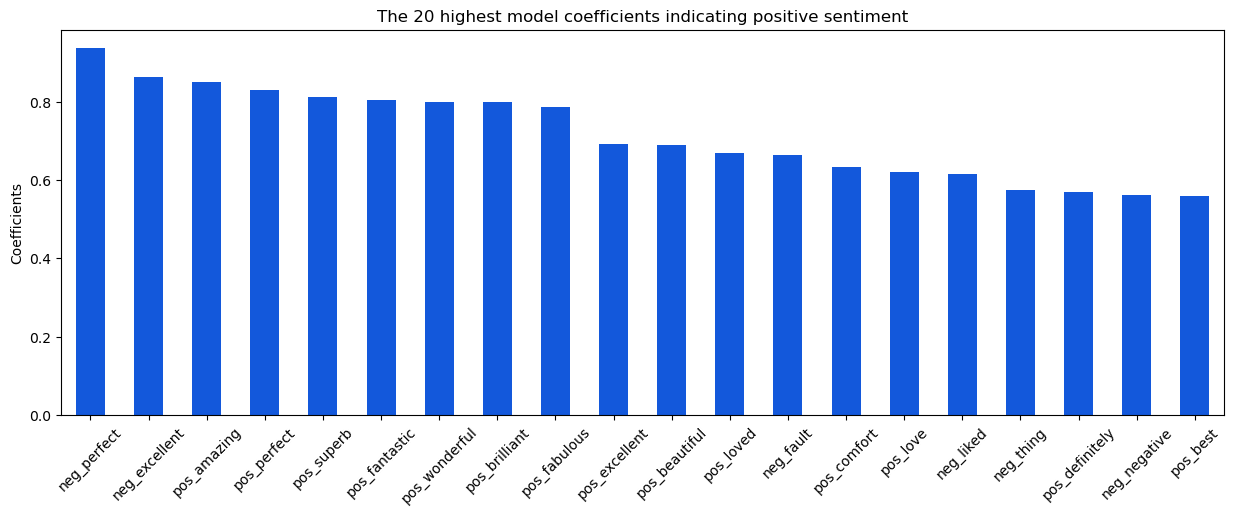

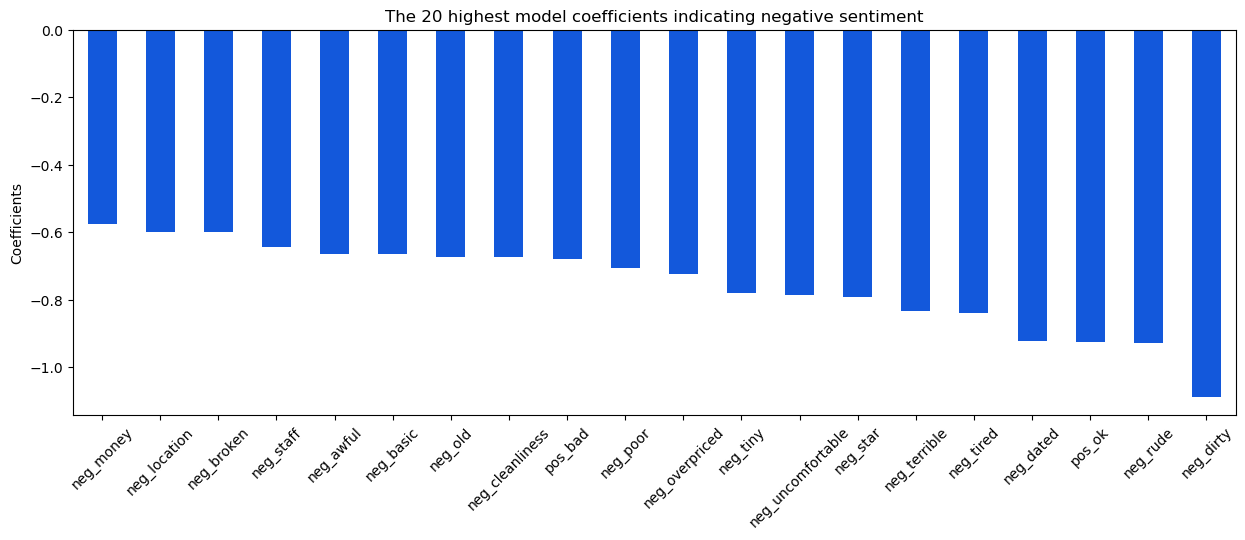

In [79]:
# Coefficients for predicting the text features
coef_values = lr.coef_[0][26:] 
coef_names= X_train_final.columns[26:]  # Selecting only the text features here
word_counts = pd.Series(coef_values, index= coef_names).sort_values(ascending=False)


plt.figure(1)
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

plt.figure(2)
word_counts.tail(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

Actionable Insights:
- Positive words highlight what guests value most (e.g., 'pos_amazing', 'pos_perfect').
- Negative words reveal common pain points (e.g., 'neg_broken', 'neg_old').
- Focusing on improving areas associated with negative words and promoting positive aspects can increase satisfaction.

### Modelling-PCA with a decision tree classifier.

Using a pipeline, combine PCA with a decision tree classifier.

Optimize at least 3 hyperparameters including the maximum tree depth and the minimum number of data points required on each leaf node.

You can use 20 principle components.

The best parameters should be found using 5-fold cross validation.

In [83]:
# Create a pipeline with PCA (e.g., 20 components) and DecisionTreeClassifier
pca_tree_pipeline = Pipeline([
    ("normalize", StandardScaler()),
    ('pca', PCA(n_components=20, random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42))
])

# Hyperparameter grid for  Decision Tree
param_grid = {
    'tree__max_depth': [3, 5, 10, 15, None],
    'tree__min_samples_leaf': [1, 2, 4, 8],
    'tree__min_samples_split': [2, 5, 10],
}


- In Pipeline, first we would scale the data to  then perform PCA to reduced the dimensionality (from 1026 to 20 components), then transforms the data and finally Decision tree is trained on this transformed data.

- 3 hypertuning parameters are considered for Decision Tree which have been defined under a certain range with stepwise increments 
- max depth has 5 possibilities to choose from, min_sample leaf has 4 and min samples split has 3. A total of 60 combinations

- Each of this combination is going to be evaluated by using 5-fold cross validation and accuracy as the scoring metric. Meaning a total of 300 models  ( 60 x 5 folds)

In [85]:

grid = GridSearchCV(
    estimator=pca_tree_pipeline,
    param_grid=param_grid,
    cv=5, #  Cross Validation folds defined in the question 
    scoring='accuracy',
    verbose=2, # prints detailed progress logs
    n_jobs=-1 #uses all CPU power to run all combinations in parallel
)

 I was having issues with memmory on my PC, so I had to take a sample of the X_train final  data set  

In [87]:
# Need to reset index on Y_train data set to match the same entries when taking a sample of data from X_train and y_train
y_train=y_train.reset_index(drop=True)
y_train

0         0
1         1
2         1
3         0
4         0
         ..
412154    0
412155    0
412156    1
412157    1
412158    1
Name: Reviewer_Score, Length: 412159, dtype: int64

In [88]:
X_train_final_sample_df=X_train_final.sample(frac=0.1,random_state=42)
y_train_final_sample_df=y_train.loc[X_train_final_sample_df.index]

In [169]:
# Fit the pipeline on the training data
grid.fit(X_train_final_sample_df, y_train_final_sample_df)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('normalize', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=20, random_state=42)),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [3, 5, 10, 15, None],
                         'tree__min_samples_leaf': [1, 2, 4, 8],
                         'tree__min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=2)

In [164]:
print("Optimized Parameters:")
print(grid.best_params_)

print("\nOptimized  Cross-Validated Accuracy:")
print(grid.best_score_)

Optimized Parameters:
{'tree__max_depth': 5, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}

Optimized  Cross-Validated Accuracy:
0.7395915126080247


In [91]:
optimized_dt_pipeline = grid.best_estimator_
optimized_dt_pipeline

Pipeline(steps=[('normalize', StandardScaler()),
                ('pca', PCA(n_components=20, random_state=42)),
                ('tree', DecisionTreeClassifier(max_depth=5, random_state=42))])

In [92]:
# Create a fresh pipeline with best parameters
optimized_pipeline = Pipeline([
    ('stand_scalar', StandardScaler()),
    ('pca', PCA(n_components=20, random_state=42)),
    ('dt', DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    ))
])

In [93]:
optimized_pipeline.fit(X_train_final, y_train)

Pipeline(steps=[('stand_scalar', StandardScaler()),
                ('pca', PCA(n_components=20, random_state=42)),
                ('dt', DecisionTreeClassifier(max_depth=5, random_state=42))])

In [94]:
# Predicted values  on Test data
y_pred_PCA_DT = optimized_pipeline.predict(X_test_final)

In [95]:
# Predicted values  on Test data
y_pred_PCA_DT = optimized_pipeline.predict(X_test_final)
print("\nClassification Report (PCA + Decision Tree on Test Data):")
print(classification_report(y_test, y_pred_PCA_DT))



Classification Report (PCA + Decision Tree on Test Data):
              precision    recall  f1-score   support

           0       0.72      0.66      0.69     44297
           1       0.76      0.81      0.78     58743

    accuracy                           0.74    103040
   macro avg       0.74      0.73      0.73    103040
weighted avg       0.74      0.74      0.74    103040



### Comparison of LR with PCA + DT 

Contrast the best results here with the logistic regression model and provide any insights that you may draw from the results.

**Classification Report (Logistic Regression on Test Data)**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.77      | 0.72   | 0.74     | 44,297  |
| 1     | 0.80      | 0.84   | 0.82     | 58,743  |

**Overall Metrics**

- **Accuracy:** 0.79  
- **Macro Avg:** Precision: 0.79 | Recall: 0.78 | F1-Score: 0.78  
- **Weighted Avg:** Precision: 0.79 | Recall: 0.79 | F1-Score: 0.79  
- **Total Support:** 103,040


**Classification Report (PCA + Decision Tree on Test Data)**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.72      | 0.66   | 0.69     | 44,297  |
| 1     | 0.76      | 0.81   | 0.78     | 58,743  |

**Overall Metrics**

- **Accuracy:** 0.74  
- **Macro Avg:** Precision: 0.74 | Recall: 0.73 | F1-Score: 0.73  
- **Weighted Avg:** Precision: 0.74 | Recall: 0.74 | F1-Score: 0.74  
- **Total Support:** 103,040


**Insights**

1. Logistic Regression Outperforms PCA + DT

Across all key metrics (accuracy, precision, recall, F1-score), Logistic Regression performs better.This is especially true for the   minority class (class 0), where PCA + DT struggles more (Recall drops from 0.72 → 0.66).

2. Dimensionality Reduction with PCA May Hurt Performance

Applying PCA before Decision Tree likely removed some useful feature variance.

Since Decision Trees do not benefit from PCA (they aren't affected by multicollinearity or feature scaling), PCA might have suppressed valuable decision boundaries.

3. Logistic Regression Benefits from High-Dimensional Linear Separation

Logistic Regression, being a linear model, performs well if the classes are separable in the original feature space.It may have leveraged more features than the reduced set from PCA, capturing richer structure in the data.

4. Model Choice Matters More Than Preprocessing

A simpler linear model (Logistic Regression) with full data outperformed a non-linear model (Decision Tree) with reduced data.This highlights the importance of tailoring preprocessing to the model's strengths.

Since our  best performing model is Logistic Regression in this case- we will proceed with conducting a more in-depth evaluation by analyzing the confusion matrix and commenting on the model errors and metrics such as precision and recall.

### Confusion matrix, Precision and Recall Scores

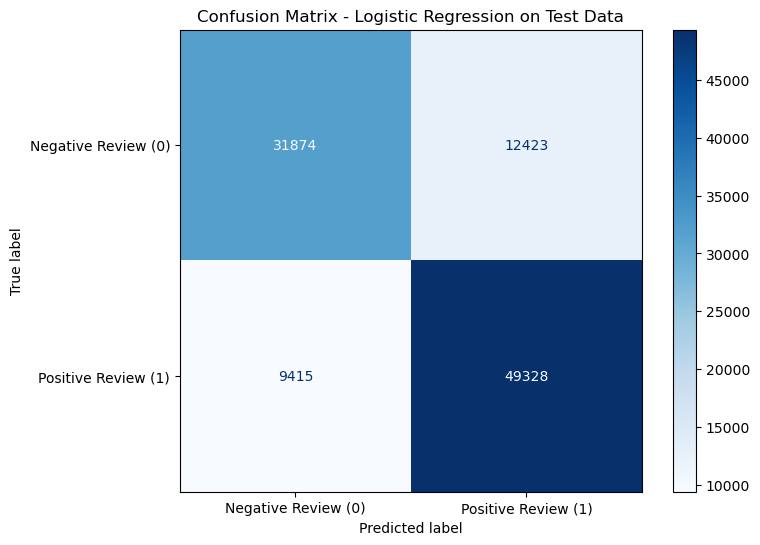

In [103]:


cm = confusion_matrix(y_test, y_pred_logreg) 

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative Review (0)", "Positive Review (1)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression on Test Data")
plt.show()


**Confusion Matrix Summary**

|                                 | **Predicted: 0**       | **Predicted: 1**        | **Total (True)** |
| ------------------------------- | ---------------------- | ----------------------- | ---------------- |
| **Actual: 0 (Negative Review)** | 31,874 (True Negative) | 12,423 (False Positive) | 44,297           |
| **Actual: 1 (Positive Review)** | 9,415 (False Negative) | 49,328 (True Positive)  | 58,743           |
| **Total (Predicted)**           | 41,289                 | 61,751                  | 103,040          |





**Error Analysis**

**False Positives (12,423)**

* **Interpretation**: These are negative reviews incorrectly classified as positive.

**False Negatives (9,415)**

* **Interpretation**: These are positive reviews misclassified as negative.

---

**Metric Breakdown**

**Class 0 (Negative Review):**

* **Precision** = TN / (TN + FN) = 31,874 / (31,874 + 9,415) ≈ **0.77**
  *→ Of all predicted negatives, 77% were correct.*

* **Recall** = TN / (TN + FP) = 31,874 / (31,874 + 12,423) ≈ **0.72**
  *→ Only 72% of actual negatives were correctly identified.*

* **F1 Score** = Harmonic mean of precision and recall ≈ **0.74**

**Class 1 (Positive Review):**

* **Precision** = TP / (TP + FP) = 49,328 / (49,328 + 12,423) ≈ **0.80**
  *→ Of all predicted positives, 80% were correct.*

* **Recall** = TP / (TP + FN) = 49,328 / (49,328 + 9,415) ≈ **0.84**
  *→ 84% of actual positives were correctly identified.*

* **F1 Score** ≈ **0.82**

---




**Key Insights**

1. **High Precision for Positive Reviews (0.80)**

   * Indicates strong confidence in predicting positive sentiment correctly.

2. **Lower Recall for Negative Reviews (0.72)**

   * Indicates a risk of **missing many negative reviews**

3. **Bias Toward Positive Reviews**

   * Model favors predicting positive sentiment more often, as seen in:

     * Higher number of predictions for class 1 (61,751) vs class 0 (41,289)
     * Better metrics for class 1 across the board.






## Conclusion


In this project, we built models to predict hotel review sentiment using text and numeric features.

- Initally, EDA was done to explore relationship between different features
- All texts were converted to numeric form by using CountVectorizer
- Logistic Regression  & PCA + DT Modelling was established.
- Evaluation of modelling was done using classification reports and confusion matrix, with emphasis on Precision and Recall Scores.

 **Results**:
- Logistic Regression outperformed the PCA + Decision Tree pipeline, achieving higher accuracy (~78%), stronger recall for positive reviews and better precision scores.
- Decision Tree + PCA performed slightly worse (~74% accuracy), highlighting trade-offs between dimensionality reduction and predictive power.

 **Key insights**:

- Positive words like amazing, perfect, fantastic were strong predictors of positive sentiment.
- Negative words such as dirty, bad, uncomfortable were strong indicators of negative sentiment.
- The confusion matrix showed most errors came from false positives (negative reviews predicted as positive).

**Future Recommendations**:

- Try more hypertune parameter optimization for Logistic Regression (C, Solver & Penalty) and evaluate the models 
- Try using TF-IDF Vecotrization instea of Bag of Words (Count Vectorizer)
- Explore other ensemble methods like Random Forest, Gradient Boosting etc.


